# Red neuronal mixta conjunta con datos numéricos e imágenes
Para esta parte final, se parte de los datasets ya separados en train y test. Contienen los datos numéricos además se usa la ruta de la imagen en el mismo orden que los datasets numéricos de train y test.

Estos datasets se obtuvieron en el notebook dedicado al tratamiento de datos. [Tratamiento de datos](limpiezaCategEscalado.ipynb)

In [1]:
import os
import pandas as pd

# Carga el dataset y devuelve un dataframe de Pandas
def load_airbnb_dataset(ruta,nombre):
    csv_path = os.path.join(ruta, nombre)
    return pd.read_csv(csv_path, sep=';')

## Carga de datasets

In [2]:
train = load_airbnb_dataset('datasets','trainFinal.csv')
test = load_airbnb_dataset('datasets','testFinal.csv')
dfTrainImagenes = load_airbnb_dataset('datasets','imagenesTrainFinal.csv')
dfTestImagenes = load_airbnb_dataset('datasets','imagenesTestFinal.csv')

## Carga de imágenes

In [3]:
import cv2
import os
import numpy as np

def cargaImagenes(dataF):
    inputImages = []

    origHeight = 144
    origWidth = 216
    origChann = 3

    for ruta in dataF['imagenLocal']:
        image = cv2.imread(ruta)

        height, width, channels = image.shape

        if (height != origHeight) or (width != origWidth) or (channels != origChann):
            raise ValueError('Tamaño incorrecto en imagen:', ruta)
        
        inputImages.append(image)

    return np.array(inputImages)

In [4]:
imagenesTrain = cargaImagenes(dfTrainImagenes)
imagenesTest = cargaImagenes(dfTestImagenes)

## Escalado de datos
### Escalar imágenes en rango de 0,1

In [5]:
imagenesTrain = imagenesTrain / 2550.
imagenesTest = imagenesTest / 2550.

### Escalar datos numéricos

In [6]:
from sklearn import preprocessing

# Separar la Y del resto
dataPrecio = train['Price']
dataSinPrecio = train.drop(['Price'], axis=1, inplace=False)

dataPrecioTest = test['Price']
dataSinPrecioTest = test.drop(['Price'], axis=1, inplace=False)

y_train = dataPrecio.values
X_train = dataSinPrecio.values

y_test = dataPrecioTest.values
X_test = dataSinPrecioTest.values

feature_names = train.columns[:]

# Obtener precio máximo en Train, y escalamos los precios de test y train en rango de [0, 1]
maxPrice = train["Price"].max()
trainY = train["Price"] / maxPrice
testY = test["Price"] / maxPrice

# Se escala las variables numéricas de train y test
scaler = preprocessing.StandardScaler().fit(X_test)
XtestScaled = scaler.transform(X_test)

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

## Red neuronal (MLP)

In [7]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

def create_mlp(dim):
    model = Sequential()
    model.add(Dense(10, input_dim=dim, activation="relu"))    
    model.add(BatchNormalization())
        
    return model

Using TensorFlow backend.


## Red Neuronal Convolucional (CNN)

In [8]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(10)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

## Creación de modelos / Concatenación MLP con CNN / Obtención del modelo final
Obtenemos ahora el modelo MLP y el CNN, luego se concatena y generamos un nuevo modelo con la unión final.

In [9]:
from keras.layers import concatenate

# create the MLP and CNN models
mlp = create_mlp(XtrainScaled.shape[1])
cnn = create_cnn(216, 144, 3, regress=False)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Compilamos y entrenamos el modelo

In [10]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# train the model
print("[INFO] training model...")
historico = model.fit(
	[XtrainScaled, imagenesTrain], trainY,
	validation_data=([XtestScaled, imagenesTest], testY),
	epochs=200, batch_size=8)

===========] - 33s 4ms/step - loss: 28.0543 - val_loss: 28.1741
Epoch 16/200
8262/8262 [==============================] - 32s 4ms/step - loss: 28.3897 - val_loss: 29.0487
Epoch 17/200
8262/8262 [==============================] - 32s 4ms/step - loss: 27.7149 - val_loss: 29.0508
Epoch 18/200
8262/8262 [==============================] - 32s 4ms/step - loss: 27.9503 - val_loss: 28.5798
Epoch 19/200
8262/8262 [==============================] - 32s 4ms/step - loss: 27.7729 - val_loss: 28.6547
Epoch 20/200
8262/8262 [==============================] - 32s 4ms/step - loss: 27.7174 - val_loss: 29.0551
Epoch 21/200
8262/8262 [==============================] - 32s 4ms/step - loss: 27.5310 - val_loss: 28.0410
Epoch 22/200
8262/8262 [==============================] - 32s 4ms/step - loss: 27.2779 - val_loss: 28.6544
Epoch 23/200
8262/8262 [==============================] - 32s 4ms/step - loss: 27.2309 - val_loss: 28.4718
Epoch 24/200
8262/8262 [==============================] - 32s 4ms/step - loss: 2

Se observa overfitting y se obtiene un error del 19% en train y del 30% en test

## Curva de pérdidas (plot)

Text(0, 0.5, 'Loss')

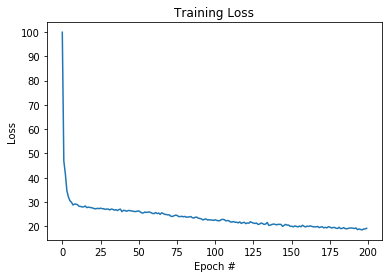

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0, 200), historico.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

## Evaluación del modelo mixto final

In [14]:
import locale

print("[INFO] predicting house prices...")
preds = model.predict([XtestScaled, imagenesTest])

# Cargar dataset original
df = load_airbnb_dataset('datasets', 'datasetImagenesFinal.csv')

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "es_ES.UTF-8")
print("[INFO] media precio apartamento: {}, desviación precio apartamento: {}".format(
	locale.currency(df["Price"].mean(), grouping=True),
	locale.currency(df["Price"].std(), grouping=True)))
print("[INFO] media: {:.2f}%, desviación: {:.2f}%".format(mean, std))

[INFO] predicting house prices...
[INFO] media precio apartamento: 68,24 €, desviación precio apartamento: 68,01 €
[INFO] media: 30.05%, desviación: 25.79%


# Resultados
La red mixta resulta tener una pérdida del 19,22% en train y un 30,05% en test.

El cálculo de error absoluto es del 30,05% y una desviación del 25,79%.